## Preamble

### Are You in the Right Place?

The following is part of a multi-part introduction to data science for those in the legal profession. The full collection of materials can be found on the Suffolk LIT Lab's How To page under the heading [Demystify Data Science](http://suffolklitlab.org/howto/#demystified). If you've followed the instructions found at [How to Train a Model](http://suffolklitlab.org/howto/demystified/2/), you should have this notebook running as opposed to viewing a preview. That means that you can run the code fond below, not to mention, read and write files to your own copy of this library.

### A Quick Test/How To
To run the code in a given cell (one of the gray boxes), make sure that it has focus (i.e., is highlighted by a bounding box), then click the "Run" button in the menu above. Alternatively, you can press `Shift+Enter`. To give a cell focus, just click on the cell. Lets give it a try. **Run the cell below.**

In [1]:
print("Yay! It worked.")

Yay! It worked.


If the text "Yay! It worked." appeared after the cell, it worked. Yay! FYI, you are welcome to join the LIT Lab's Slack Team. There you can ask and answer questions relating to this lesson under the [#howto-datasci](https://suffolklitlab.slack.com/messages/CAKMYBRL0/) channel. See the Lab's [How To](file:///H:/LITLab/SuffolkLITLab.github.io/howto/) for more. That being said, let's get to the main course. 

As you come upon cells, run them. FYI, the text blocks are actual cells too. So it's perfectly reasonable to press `Shift+Enter` to move your way down the page. If you want to see how we format text, double click on one of the text blocks and you'll see something called [markdown](https://en.wikipedia.org/wiki/Markdown). You can set a cell to "Code" or "Markdown" in a pulldown menu above. We're not going to do anything with Markdown here, but I thought you'd like to know. Anywho, to convert the Markdown back to text, just run the cell.  

# How to Train a Model

Okay, we're approaching the Danger Zone you were warned about back in [Why Data Science](http://suffolklitlab.org/howto/demystified/0/). That is, you're about to learn just enough to be dangerous. 

![Data Science](http://static1.squarespace.com/static/5150aec6e4b0e340ec52710a/t/51525c33e4b0b3e0d10f77ab/1364352052403/Data_Science_VD.png?format=750w) 

What follows shouldn't be approached without more context. If you're taking a LIT lab course, that context will come through lecture. For everyone else, the following two articles may help a little:

- [Uncovering Big Bias with Big Data](https://lawyerist.com/big-bias-big-data/), which is mostly an introduction to linear regression driven by a law-themed question. 
- [Portland’s Precrime Experiment and the Limits of Algorithms](https://lawyerist.com/precrime-in-portland-a-canary-in-the-data-mine/), in which there is a discussion of the generic workflow of training a model. 

Please take a moment to read the above before continuing. 

Alright, let's go ahead and load Pandas. 

In [2]:
import pandas as pd

Now we can load the data that we cleaned in [Data Wrangling and Feature Engineering](http://suffolklitlab.org/howto/demystified/1/).

In [3]:
processed_table = pd.read_csv('processed_table_only_numbers.csv') 
processed_table.head()

,accum,min,max,wind,yesterdays_high,closed
1,0.0,60.21,67.46,4.80,70.80,0
3,0.0,59.72,61.98,9.91,73.83,0
4,0.0,58.36,65.14,6.01,61.98,0
5,0.0,60.61,77.83,5.21,65.14,0
7,0.0,65.55,82.86,8.69,80.11,0


## Linear Regression

I'm now going to make a set of tables to be used in training and testing some models. This process should be familiar to you from the two articles linked above ([Uncovering Big Bias with Big Data](https://lawyerist.com/big-bias-big-data/) and  [Portland’s Precrime Experiment and the Limits of Algorithms](https://lawyerist.com/precrime-in-portland-a-canary-in-the-data-mine/)).

Remember, linear regression is used to predict continuous values (things that fall on a number line). I know we talked earlier (in the last notebook) about predicting snow days, but that's not a very good use case for linear regression. It's designed for predicting some number on a number line. So here I'm going to try to predict today's high using yesterday's. So I'll need the target (max) and the feature (yesterdays_high).

In [4]:
lin_df = processed_table[[
                               'max',
                               'yesterdays_high'
                               ]].copy()
lin_df.head()

,max,yesterdays_high
1,67.46,70.80
3,61.98,73.83
4,65.14,61.98
5,77.83,65.14
7,82.86,80.11


If I want a really quick and dirty look at things, I can plot these two making use of the seaborn library. Note: this may take a moment or two, and it's likely to throw a warning, but in the end you should get a pretty plot.

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


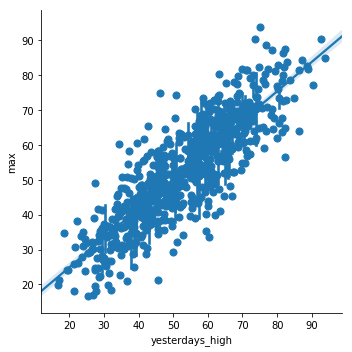

In [5]:
# load library
import seaborn as sns
# Tell this notebook to display plots in the page
%matplotlib inline
# This library does fun math on arrays of numbers
import numpy as np

# run simple linear regression using seaborn
sns.lmplot(x="yesterdays_high", y="max", data=lin_df, x_estimator=np.mean, order=1)

In practice, we'd probably want to use more than one feature, but this one-to-one construction works well for an introduction. What we see is that yesterday's high is corelated with today's high. That is, as one goes up, the other does the same. 

Okay, what about overfitting? Yep, I'm using a vocabulary word from the [reading](https://lawyerist.com/big-bias-big-data/). To address that concern let's do a proper training of the data using training and holdout dataframes. That is, we'll set some amount of the data aside (holdout), train our model on what remains, and then check and see how the model does on the data it hasn't seen. 

In [6]:
# create a dataframe containing a random sample of lin_df rows
lin_holdout = lin_df.sample(frac=0.20) # 0.20 = 20%

# create a dataframe that conatins the rows from lin_df except for those in lin_holdout
lin_training = lin_df.loc[~lin_df.index.isin(lin_holdout.index)]

print("size of training",len(lin_training))

size of training 588


In [7]:
# I like the statsmodels regression library because it comes with a nice summary.
# So let's load the library and run the regression on our training data. 

from statsmodels.formula.api import ols

model = ols("max ~ yesterdays_high", lin_training).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    max   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     1407.
Date:                Tue, 15 Oct 2019   Prob (F-statistic):          6.90e-158
Time:                        20:18:57   Log-Likelihood:                -2059.8
No. Observations:                 588   AIC:                             4124.
Df Residuals:                     586   BIC:                             4132.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           7.9712      1.237      6.442      0.000       5.541      10.401
yesterdays_high     0.8447      0.023     37.508      0.000       0.801       0.889
==============================================================================
Omnibus:                        2.794   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.247   Jarque-Bera (JB):                2.980
Skew:                          -0.042   Prob(JB):                        0.225
Kurtosis:                       3.338   Cond. No.                         205.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There are two main numbers we're looking at the R-squared and the P-values. 

We have yet to check the model against our holdout data, and it so happens that another implementation of the linear regression algo can be found over at scikitlearn. It makes evaluating against the holdout data rather simple. 

In [8]:
# Rerun with SciKitLearn because it's easy to check accuracy

from sklearn import linear_model
from sklearn import metrics

# make a training dataframe containing just features
features_train = lin_training.drop("max", axis=1).as_matrix(columns=None)

# make a training dataframe containing only the target
target_train = lin_training["max"].as_matrix(columns=None)

# make a testing/holdout dataframe containing just features
features_test = lin_holdout.drop("max", axis=1).as_matrix(columns=None)

# make a testing/holdout dataframe containing only the target
target_test = lin_holdout["max"].as_matrix(columns=None)

# run the regression
lm = linear_model.LinearRegression()
reg = lm.fit(features_train, target_train)
print("R squared (training):",lm.score(features_train,target_train)) # this sould be the same as above

# create a dataframe of predictions based on the test features
pred = reg.predict(features_test)
# compare these predictions to the actual values
variance = metrics.r2_score(target_test, pred)
print("Variance score (test):",variance)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


R squared (training): 0.7059540330197795
Variance score (test): 0.7310048549720367


So our model "explains" about 70% of the variance for both our training and holdout data. It turns out the temperature yesterday is a pretty good predictor for the temperature today. Imagine how good we'd be at prediction if we added a few other relevant features or if we lived in California (I'm told the weather is always the same ;)

# Classifiers

Now let's get back to predicting snow days. To predict a snow day we need a model that spits out a categorical value (i.e., a label like yes or no). This differs from a continuous value, like those we were looking at above. To make things simple, we're going to have yes = 1 and no =0. That being said, let's clean up our processed table accordingly.

In [9]:
# Note: the question of what features to include is beyond the scope of this post. 
# We'll just say these all look like they could help predict a snow day.

class_df = processed_table[[
                               'accum', 
                               'min', 
                               'max',
                               'closed'
                               ]].copy()
class_df.head()

,accum,min,max,closed
1,0.0,60.21,67.46,0
3,0.0,59.72,61.98,0
4,0.0,58.36,65.14,0
5,0.0,60.61,77.83,0
7,0.0,65.55,82.86,0


Here's a little function to help evaluate how good our classifiers are. It produces the terms for a confusion matrix. See https://en.wikipedia.org/wiki/Confusion_matrix

In [10]:
# I'll need these libraries to make it work
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
    
def evaluate(prob, pred, labels_test, verbose=1):
    acc = accuracy_score(labels_test,pred)
    ones = sum(labels_test)/len(labels_test)
    zeros = (1 - ones)
    tn, fp, fn, tp = confusion_matrix(labels_test, pred).ravel()

    recall_ = tp / (tp + fn) 
    precision_ = tp / (tp + fp)
    f1 = (2 / ((1/recall_)+(1/precision_)))

    false_positive_rate, true_positive_rate, thresholds = roc_curve(labels_test,prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    if verbose==1:
        
        plt.rcParams['figure.figsize'] = [14, 4]
        
        plt.subplot(1, 3, 1)
        plt.title('Receiver Operating Characteristic')
        plt.plot(false_positive_rate, true_positive_rate, 'b',
        label='AUC = %0.2f'% roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1],[0,1],'r--')
        plt.xlim([-0.1,1.2])
        plt.ylim([-0.1,1.2])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')

        precision, recall, thresholds = precision_recall_curve(labels_test,prob)

        plt.subplot(1, 3, 2)
        plt.title('Precision-Recall Curve')
        plt.plot(recall, precision,'b',
        label='AP = %0.2f'% precision.mean())
        plt.legend(loc='lower right')
        plt.xlim([-0.1,1.2])
        plt.ylim([-0.1,1.2])
        plt.ylabel('Recall')
        plt.xlabel('Precision')

        plt.subplot(1, 3, 3)
        plt.hist([labels_test,prob], label=["true","pred"], bins='auto')  # arguments are passed to np.histogram
        plt.title("Predictions vs Reality")
        plt.legend(loc='best')
        plt.xlim([-0.1,1.2])

        plt.tight_layout()
        plt.show()    

        print ("\n0s: %0.2f\tTrue Positives: %s\tAccuracy: %s "%(zeros,tp,acc))
        print ("1s: %0.2f\tTrue Negatives: %s\tAUC: %s"%(ones,tn,roc_auc))
        print ("\t\tFalse Positives: %s\tF1 Score: %s"%(fp,f1))
        print ("\t\tFalse Negatives: %s\tRecall (fract of actual yeas found): %s"%(fn,recall_))
        print ("\t\t\t\t\tPrecision (correctness of yeas predicted): %s\n"%precision_)        
        
        null = zeros
        if null < ones:
            null = ones
        
        if (acc>null) and (roc_auc>0.5) and (recall_>0.5) and (precision_>0.5):
            print("################")
            print("#     PASS     #")
            print("################")
            vpass = "Yes"
        else:
            print("################")
            print("#     FAIL     #")
            print("################")
            vpass = "No"
          
    #return ones,vpass,null,acc,roc_auc,recall_,precision_,f1

And of course we need training and holdout data.

In [11]:
# create a dataframe containing a random sample of rows
class_holdout = class_df.sample(frac=0.20)

# create a dataframe that conatins the rows from except for those in holdout
class_training = class_df.loc[~class_df.index.isin(class_holdout.index)]

# make a training dataframe containing just features
features_train = class_training.drop("closed", axis=1).as_matrix(columns=None)

# make a training dataframe containing only the target
labels_train = class_training["closed"].as_matrix(columns=None)

# make a testing/holdout dataframe containing just features
features_test = class_holdout.drop("closed", axis=1).as_matrix(columns=None)

# make a testing/holdout dataframe containing only the target
labels_test = class_holdout["closed"].as_matrix(columns=None)

print("size of training",len(class_training))

size of training 588


/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Now just to keep ourselves honest, let's ask, "What percentage of the time is target 0?"

In [12]:
print("Percentage of 0s: %s\n"%(len(class_df[class_df["closed"]==0])/len(class_df)))

# This is a useful question because it helps us not be overly impressed by the accuracy of our models. 
# How? Well, apparently, if I always guessed that we wouldn't have a snow day I'd be right ~98% of the time.

Percentage of 0s: 0.9823129251700681



What follows is the feeding or our data to a bunch of different classification algorithms. The "best" models will have the highest F1 score. At least, that's how we'll define best at the moment. For a primer on what all the outputs mean, check out this article on the [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

Note, they may or may not work depending on the contents of your training data. Since there are so few school closings, it's possible you won't get enough of them in the training data for the algos to work. When this happens you'll likely see a pink error message with something like "divide by zero encountered." If this happens and you really want the pink to go away, rerun the cell above where you create the training and holdout dataframes. When you use bigger datasets this shouldn't be an issue. 

I've provided links to documentation on each of the classification algos so you can investigate what they're doing under the hood. That being said, this documentation is probably not the best introduction. So you may want to consider Googling their names. Alternatively, if you're part of the Lab, we'll talk more about these in class.

First up, Logistic Regression: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression


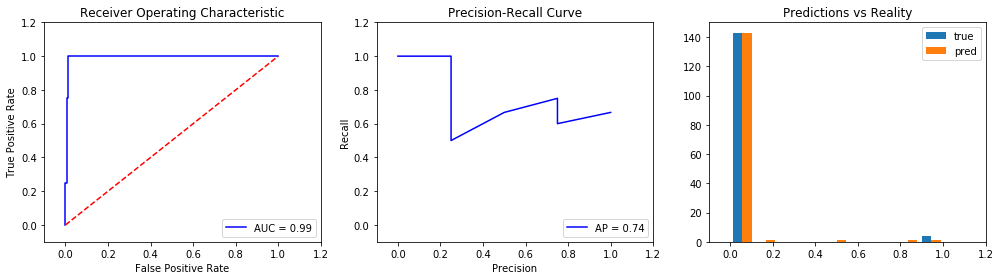


0s: 0.97	True Positives: 1	Accuracy: 0.9727891156462585 
1s: 0.03	True Negatives: 142	AUC: 0.993006993006993
		False Positives: 1	F1 Score: 0.3333333333333333
		False Negatives: 3	Recall (fract of actual yeas found): 0.25
					Precision (correctness of yeas predicted): 0.5

################
#     FAIL     #
################


In [13]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression
model = LogisticRegression(fit_intercept = False, C = 1e9)
clf_1 = model.fit(features_train, labels_train)
pred = clf_1.predict(features_test)
prob = clf_1.predict_proba(features_test)[:,1] 
print("Logistic Regression")
evaluate(prob, pred, labels_test)  

Decision Tree Classifier: http://scikit-learn.org/stable/modules/tree.html#tree


Decision Tree


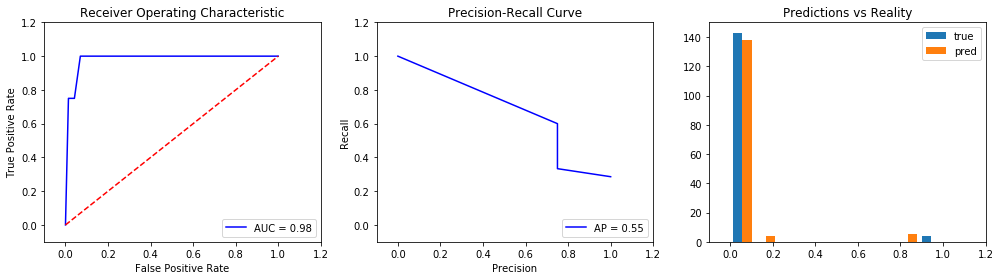


0s: 0.97	True Positives: 3	Accuracy: 0.9795918367346939 
1s: 0.03	True Negatives: 141	AUC: 0.9807692307692308
		False Positives: 2	F1 Score: 0.6666666666666666
		False Negatives: 1	Recall (fract of actual yeas found): 0.75
					Precision (correctness of yeas predicted): 0.6

################
#     PASS     #
################


In [14]:
from sklearn import tree
clf_2 = tree.DecisionTreeClassifier(min_samples_split=40)
clf_2 = clf_2.fit(features_train, labels_train)
pred = clf_2.predict(features_test)
prob = clf_2.predict_proba(features_test)[:,1] 
print("\nDecision Tree")
evaluate(prob, pred, labels_test)

Random Forest: http://scikit-learn.org/stable/modules/ensemble.html#forest

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in long_scalars
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in double_scalars


Random Forest


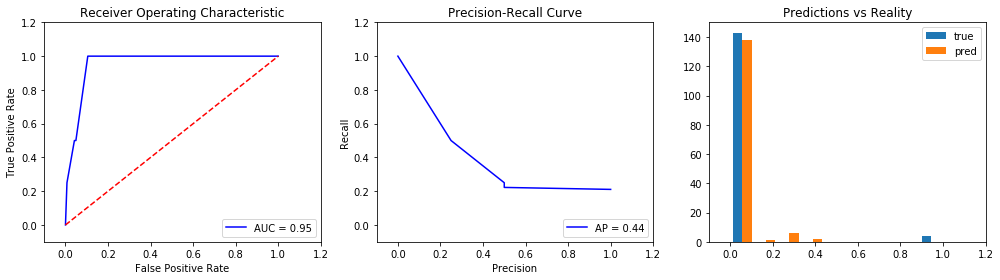


0s: 0.97	True Positives: 0	Accuracy: 0.9727891156462585 
1s: 0.03	True Negatives: 143	AUC: 0.9545454545454546
		False Positives: 0	F1 Score: nan
		False Negatives: 4	Recall (fract of actual yeas found): 0.0
					Precision (correctness of yeas predicted): nan

################
#     FAIL     #
################


In [15]:
from sklearn.ensemble import RandomForestClassifier
clf_3 = RandomForestClassifier()
clf_3 = clf_3.fit(features_train, labels_train)
pred = clf_3.predict(features_test)
prob = clf_3.predict_proba(features_test)[:,1] 
print("Random Forest")
evaluate(prob,pred, labels_test)  

Support Vector Machines: http://scikit-learn.org/stable/modules/svm.html#svm-classification

In [ ]:
from sklearn.svm import SVC
clf_4 = SVC(kernel="rbf",probability=True)
clf_4 = clf_4.fit(features_train, labels_train)
pred = clf_4.predict(features_test)
prob = clf_4.predict_proba(features_test)[:,1] 
print("SVM")
evaluate(prob, pred, labels_test)  

To actually use your models we use `.predict()`. All you do is pass your model a list of feature values. You can actually pass a multi-dimensional array of values (basically a table), but here we'll limit ourselves to a simple list. The ability to pass an array however, is why you see bracketed numbers after `.predict()`. They're asking that the output only focus on the bits we want. 

In [16]:
# What classifier do you want to use? Above, each one is 
# given it's own number (e.g., clf_1, clf_2, etc.)
clf = clf_2

# Set the values for each of the above features: accum, min, max
inputs = [30,-20,50]

guess = clf.predict([inputs])[0]
print("Model's Guess:",guess)

if guess == 0:
    probability = clf.predict_proba([inputs])[0][0]
else:
    probability = clf.predict_proba([inputs])[0][1]
    
print("Confidence the guess is right:",probability)

Model's Guess: 1
Confidence the guess is right: 0.7777777777777778


Okay, now back to that multi-dimensional array. `features_test` is just such an array. So `pred_[number]` is just a list of numbers (1= snow day and 0= no snow day) for that list. Here's the list of features (a list of lists with three numbers per "row"):  

In [78]:
features_test[:3] # the [:3] is just a way to say, show only the first three "rows".

array([[ 0.  , 37.85, 46.02],
       [ 0.  , 51.56, 64.83],
       [ 0.  , 49.06, 66.89]])

You may have guessed it, but an array is just another datatype, it's kind of like a dataframe but it's a list of lists where the lists are numbers. Anywho. You can feed this array into your model like so:

In [81]:
clf.predict(features_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

And as you can see each of the numbers in `pred` corresponds to either a 1 (snow day) or a 0 (no snow day).

When you get to the [Gut Decision Challenge](http://suffolklitlab.org/howto/demystified/4/), this bit above will become useful. ;)

Let's say that for example, I wanted to take the data from above and see for what accumulations the algo predicted school would be closed. Then I could pass it our feature data (`features_test`), marry it to our acummulation data, and filter by `1`s. 

In [82]:
features_test[:,0] # This is just the way to get the first 0ith column of data in the feature test array. 

array([0.   , 0.   , 0.   , 1.857, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 4.196, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 1.44 , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.359,
       0.   , 0.036, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.852, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.263, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.185, 0.   , 0.   , 0.   ,
       0.   , 0.   ,

So now I can produce a similar array of accumulations and marry the two together into a dataframe where I can filter out predictions of `0`. Like so:

In [85]:
percentile_list = pd.DataFrame(
    {'accum': features_test[:,0], 'pred': clf.predict(features_test)
    })
percentile_list[percentile_list["pred"]==1]

,accum,pred
13,4.196,1


ProTip: This only works because the order of the accumulation list and the prediction list are the same. If I wanted to do something like figure out the dates on which the algo predicted a closing, I would need a list with the same order. This means you have to think about when you get rid of columns because you might want them later on. 